In [1]:
import cmocean

import numpy as np
import pandas as pd

from netCDF4 import Dataset

from matplotlib import pyplot as plt
import matplotlib.animation as animation

import cartopy.crs as ccrs
import cartopy.feature as cfeature

In [2]:
dataset = Dataset('2025_KVS_deployment_nonQCdata_v01.nc',  mode='r', format='NETCDF4')

In [3]:
print(dataset['trajectory'][:])

['2025_04_KVS_SvalMIZ_01' '2025_04_KVS_SvalMIZ_02'
 '2025_04_KVS_SvalMIZ_03' '2025_04_KVS_SvalMIZ_04'
 '2025_04_KVS_SvalMIZ_05' '2025_04_KVS_SvalMIZ_06'
 '2025_04_KVS_SvalMIZ_07' '2025_04_KVS_SvalMIZ_08'
 '2025_04_KVS_SvalMIZ_09' '2025_04_KVS_SvalMIZ_10'
 '2025_04_KVS_SvalMIZ_11' '2025_04_KVS_SvalMIZ_14'
 '2025_04_KVS_SvalMIZ_15' '2025_04_KVS_SvalMIZ_18'
 '2025_04_KVS_SvalMIZ_19' '2025_04_KVS_SvalMIZ_20'
 '2025_04_KVS_SvalMIZ_22' '2025_04_KVS_SvalMIZ_23'
 '2025_04_KVS_SvalMIZ_24' '2025_04_KVS_SvalMIZ_25']


### Trying to copy Fig. 5 from Cruise Report of Müller et.al 

In [ ]:
def plot_report_fig5(dataset, buoy_idx, ax):
    reference_time = np.datetime64(dataset['time_temp'].units[14:])

    buoy_kvs_10_time = reference_time + dataset['time_temp'][buoy_idx, :].astype('timedelta64[s]')
    buoy_kvs_10_t1m = dataset['temp_air_raw'][buoy_idx, :]

    ax.axhline(-1.6, ls = '--', c = 'r')
    ax.plot(buoy_kvs_10_time, buoy_kvs_10_t1m, label = 'T1M')   # 1-meter temperature
    ax.plot(buoy_kvs_10_time, dataset['temp_snow_ice_raw'][buoy_idx, :], label = 'Snow-Ice interface temp')    # Snow-ice interface
    ax.plot(buoy_kvs_10_time, dataset['temp_ice_raw'][buoy_idx, :], label = 'Ice temp @ 30cm')  # Temp of ice at 30cm depth
    ax.plot(buoy_kvs_10_time, dataset['temp_mlx_ir'][buoy_idx, :], label = 'Snow surface temp')   # Snow surface
    ax.set_ylim(-13, 5)
    ax.legend()
    ax.set_title(f"{dataset['trajectory'][i]}")

    ax.grid(True)

In [5]:
print(dataset['trajectory'].shape)

(20,)


IndexError: arome_t2m not found in /

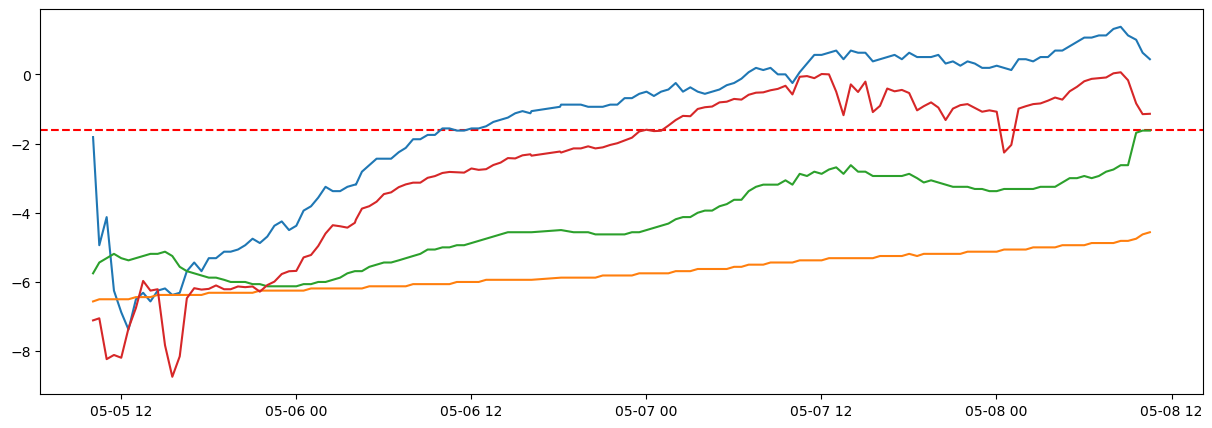

In [6]:

for i in range(dataset['trajectory'].shape[0]):
    fig, ax = plt.subplots(1, 1, figsize = (15, 5))
    plot_report_fig5(dataset, i, ax)

    fig.savefig(f"/home/arefk/phd/geo9300/GEO9300_project/presentation_images/{dataset['trajectory'][i]}.png", dpi = 300, bbox_inches = 'tight') 
    # if i != 0:
        # ax[i].legend().remove()

'''
plot_report_fig5(dataset, 5, ax[1])
ax[1].legend().remove()
plot_report_fig5(dataset, 9, ax[2])
ax[2].legend().remove()
plot_report_fig5(dataset, 12, ax[3])
ax[3].legend().remove()
plot_report_fig5(dataset, 15, ax[4])
ax[4].legend().remove()
'''


### Attempt to show lat/lon for temp times

In [ ]:
reference_time_traj = np.datetime64(dataset['time'].units[14:])


buoy_kvs_10_time_traj = reference_time_traj + dataset['time'][2, :].astype('timedelta64[s]')

print(buoy_kvs_10_time_traj)
print(np.where(np.isnat(buoy_kvs_10_time_traj), buoy_kvs_10_time_traj[0], buoy_kvs_10_time_traj).max())
# print(buoy_kvs_10_time)

buoy_kvs_10_time_diff = buoy_kvs_10_time_traj - buoy_kvs_10_time[:3070]
buoy_kvs_10_time_diff = np.where(np.isnat(buoy_kvs_10_time_diff), 0, buoy_kvs_10_time_diff)

# print(buoy_kvs_10_time_diff.max())

### Sort temp and gps into a df

In [ ]:
buoy_kvs_10_df = pd.DataFrame({'t1m': buoy_kvs_10_t1m}, index=buoy_kvs_10_time)

buoy_kvs_10_df = buoy_kvs_10_df.resample('60min').mean()


In [ ]:

buoy_kvs_10_traj_df = pd.DataFrame({'lat': dataset['lat'][buoy_kvs_10_idx, :], 'lon': dataset['lon'][buoy_kvs_10_idx, :]}, index=buoy_kvs_10_time_traj)

buoy_kvs_10_traj_df = buoy_kvs_10_traj_df.resample('60min').mean()

In [ ]:
full_df = pd.merge(buoy_kvs_10_traj_df, buoy_kvs_10_df, left_index=True, right_index=True)
full_df

### Fancy animation

In [ ]:
def create_animation():
    map_proj = ccrs.NorthPolarStereo(central_longitude=10)
    data_proj = ccrs.PlateCarree()
    fig, ax = plt.subplots(figsize = (10, 6), subplot_kw = {'projection': map_proj})

    ax.set_extent([-1, 25, 79, 82], crs = data_proj)
    ax.coastlines()
    gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)

    gl.bottom_labels = False
    gl.right_labels = False

    cb = ax.scatter([], [], c=[], cmap = cmocean.cm.thermal, transform = data_proj)
    cbar = fig.colorbar(cb, ax = ax, label = 'Temperature [T1M]')

    scatter_plots = []
    points_per_frame = max(1, len(full_df) // 50)

    def animate(frame):
        start_idx = frame * points_per_frame
        end_idx = min(start_idx + points_per_frame, len(full_df))

        if start_idx < len(full_df):
            new_lons = full_df['lon'].iloc[start_idx:end_idx].values
            new_lats = full_df['lat'].iloc[start_idx:end_idx].values
            new_temps = full_df['t1m'].iloc[start_idx:end_idx].values

            new_scatter = ax.scatter(new_lons, new_lats, c = new_temps, cmap = cmocean.cm.thermal, transform = data_proj)

            scatter_plots.append(new_scatter)

        total_points = min(end_idx, len(full_df))
        ax.set_title(f"Frame {frame + 1}")

        return scatter_plots
    
    total_frames = (len(full_df) + points_per_frame - 1) // points_per_frame

    anim = animation.FuncAnimation(fig, animate, frames = total_frames, interval = 100, repeat = True, blit = False)

    return fig, anim

In [ ]:
fig, anim = create_animation()
plt.tight_layout()
plt.show()

### Simple figure

In [ ]:
map_proj = ccrs.NorthPolarStereo(central_longitude=10)
data_proj = ccrs.PlateCarree()

fig, ax = plt.subplots(figsize = (10, 6), subplot_kw = {'projection': map_proj})

cb = ax.scatter(full_df['lon'], full_df['lat'], c = full_df['t1m'], cmap = cmocean.cm.thermal, transform = data_proj)
ax.set_extent([-1, 25, 79, 82], crs = data_proj)
ax.coastlines()
gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
gl.bottom_labels = False
gl.right_labels = False

fig.colorbar(cb)

### Copilot example
Copilot is now disabled

In [ ]:


# Print global attributes
print("Global Attributes:")
for attr in dataset.ncattrs():
    print(f"{attr}: {getattr(dataset, attr)}")

# Print dimensions
print("\nDimensions:")
for dim in dataset.dimensions.values():
    print(f"{dim.name}: {len(dim)}")

# Print variables
print("\nVariables:")
for var in dataset.variables.values():
    print(f"{var.name}: {var.dimensions}, {var.dtype}")

# Plot latitude and longitude for the first trajectory using Cartopy
lat = dataset.variables['lat'][0, :]
lon = dataset.variables['lon'][0, :]

fig = plt.figure(figsize=(10, 6))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_title('Trajectory 0: Latitude vs Longitude (Cartopy)')
ax.coastlines()
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.gridlines(draw_labels=True)
ax.plot(lon, lat, marker='o', linestyle='-', markersize=2, color='red', transform=ccrs.PlateCarree())
plt.show()